In [1]:
%pip install -q "openvino>=2023.1.0"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
from pathlib import Path

import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import openvino as ov
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



2023-11-10 16:53:37.002394: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 16:53:37.004484: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 16:53:37.030725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 16:53:37.030755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 16:53:37.030779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
import pathlib
import tarfile
import tensorflow as tf
import lzma

# Replace 'local_path' with the actual local file path to your downloaded dataset
local_path = '../dataset/medicine_name_dataset.tar.xz'

# Unpack the dataset if needed
if not pathlib.Path(local_path.replace('.tar.xz', '')).is_dir():
    with lzma.open(local_path, 'rb') as xz_file:
        with tarfile.open(fileobj=xz_file) as tar:
            tar.extractall('')  # Replace with the desired extraction path

data_dir = pathlib.Path('medicine_name_dataset')  # Replace with your actual dataset directory


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

419


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 419 files belonging to 54 classes.
Using 336 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 419 files belonging to 54 classes.


Using 83 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['accet', 'ace_plus', 'acitix', 'adropin', 'ambrox', 'amdocalcy', 'anistovit', 'anzet', 'atova', 'atrisive', 'avolae', 'azolin', 'bost', 'caldi', 'capcet', 'caryon', 'coralceel', 'dexlin', 'dm_a', 'earo_zenole', 'easyl3fe', 'ecospin', 'edeloss', 'etoxib', 'ezylifel', 'fexo', 'flexi', 'fluclox', 'folict', 'iprasol', 'levoflex', 'lopo', 'monas', 'monaz', 'myolax', 'napa', 'napa-rapid', 'others', 'oticlor_pd', 'otosil', 'potacit', 'remood', 'renava', 'revotril', 'sergel', 'solan', 'sulprex', 'supra', 'suprab', 'tamenturbo', 'tyclav', 'viset', 'xixc_b', 'zovia_gold']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)


In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.24760349 0.91872394


In [12]:
num_classes = len(class_names) + 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


11/11 [==============================] - 2s 125ms/step - loss: 4.1214 - accuracy: 0.0774 - val_loss: 3.9717 - val_accuracy: 0.0602
Epoch 2/10
11/11 [==============================] - 1s 111ms/step - loss: 3.8253 - accuracy: 0.1071 - val_loss: 3.7072 - val_accuracy: 0.0964
Epoch 3/10
11/11 [==============================] - 1s 114ms/step - loss: 3.2076 - accuracy: 0.2054 - val_loss: 2.6784 - val_accuracy: 0.4337
Epoch 4/10
11/11 [==============================] - 1s 114ms/step - loss: 1.6948 - accuracy: 0.6101 - val_loss: 1.0830 - val_accuracy: 0.7470
Epoch 5/10
11/11 [==============================] - 1s 119ms/step - loss: 0.5477 - accuracy: 0.8780 - val_loss: 0.2759 - val_accuracy: 0.9518
Epoch 6/10
11/11 [==============================] - 1s 134ms/step - loss: 0.2466 - accuracy: 0.9554 - val_loss: 0.1166 - val_accuracy: 0.9639
Epoch 7/10
11/11 [==============================] - 2s 161ms/step - loss: 0.4064 - accuracy: 0.9494 - val_loss: 0.1166 - val_accuracy: 1.0000
Epoch 8/10
11/11 

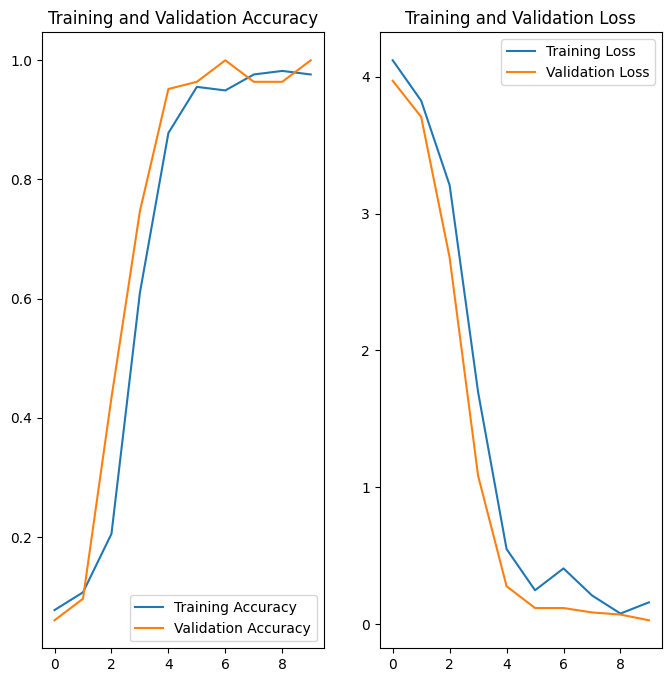

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                   img_width,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

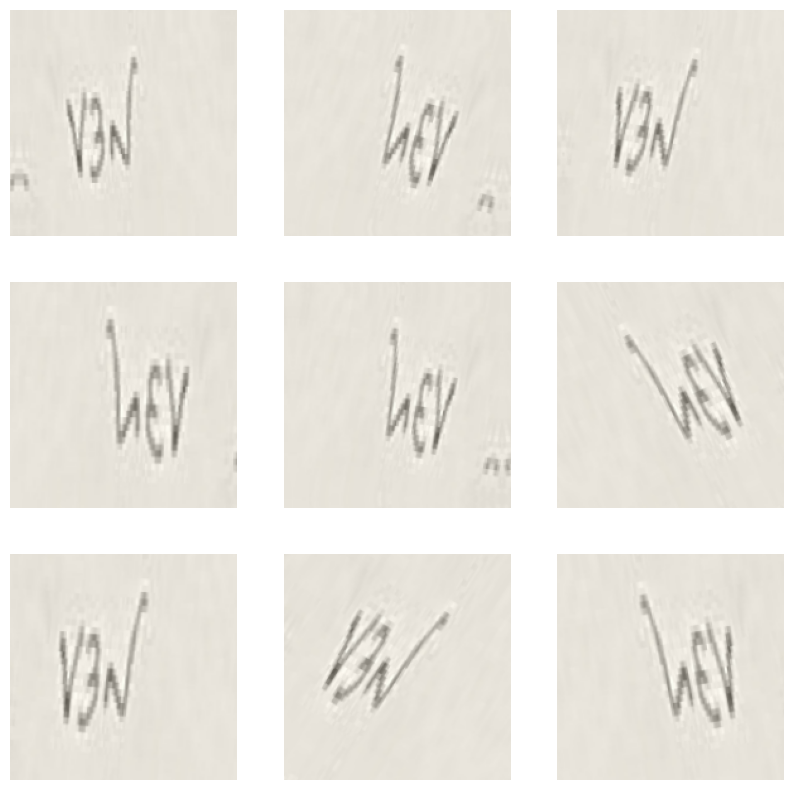

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 2s 153ms/step - loss: 4.3707 - accuracy: 0.0149 - val_loss: 3.9932 - val_accuracy: 0.0120
Epoch 2/15
11/11 [==============================] - 2s 155ms/step - loss: 3.9787 - accuracy: 0.0714 - val_loss: 3.9972 - val_accuracy: 0.0602
Epoch 3/15
11/11 [==============================] - 2s 148ms/step - loss: 3.9349 - accuracy: 0.1012 - val_loss: 3.9732 - val_accuracy: 0.0602
Epoch 4/15
11/11 [==============================] - 2s 145ms/step - loss: 3.9051 - accuracy: 0.1012 - val_loss: 3.9903 - val_accuracy: 0.0602
Epoch 5/15
11/11 [==============================] - 2s 149ms/step - loss: 3.8403 - accuracy: 0.1012 - val_loss: 3.7865 - val_accuracy: 0.0602
Epoch 6/15
11/11 [==============================] - 2s 147ms/step - loss: 3.6327 - accuracy: 0.1548 - val_loss: 3.6170 - val_accuracy: 0.1205
Epoch 7/15
11/11 [==============================] - 2s 145ms/step - loss: 3.2481 - accuracy: 0.1905 - val_loss: 3.0067 - val_accuracy: 0.3253
Epoch 

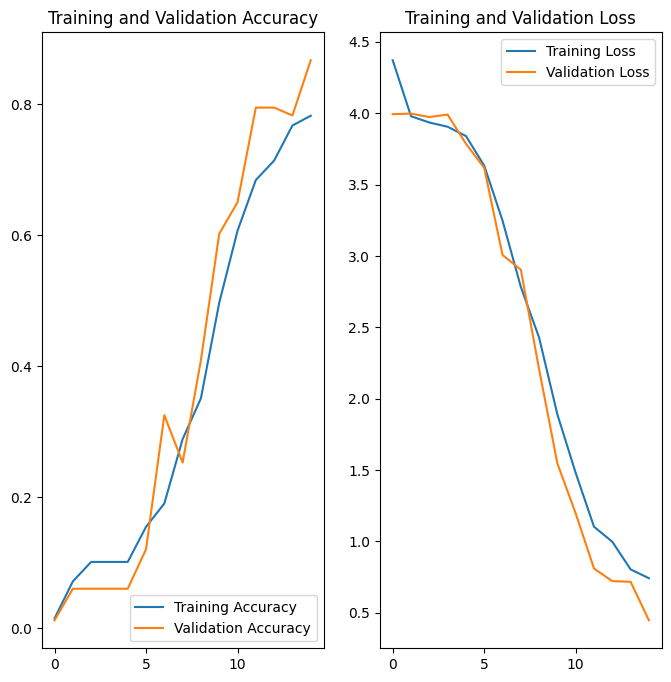

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:

image_path = "medicine_name_dataset/ambrox/1.jpg"

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to ambrox with a 73.49 percent confidence.


In [23]:

model_dir = "model"
saved_model_dir = f"{model_dir}/medicine/saved_model"
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: model/medicine/saved_model/assets


INFO:tensorflow:Assets written to: model/medicine/saved_model/assets


In [24]:
# Convert the model to ir model format and save it.
ir_model_path = Path("model/medicine")
ir_model_path.mkdir(parents=True, exist_ok=True)
ir_model = ov.convert_model(saved_model_dir, input=[1,180,180,3])
ov.save_model(ir_model, ir_model_path / "medicine.xml")

In [25]:
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

In [26]:
import ipywidgets as widgets

# Initialize OpenVINO runtime
core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [27]:
# class_names=["solan", "vasco"]

compiled_model = core.compile_model(model=ir_model, device_name=device.value)

del ir_model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

(1, 180, 180, 3)
[1,180,180,3]
This image most likely belongs to ambrox with a 65.21 percent confidence.


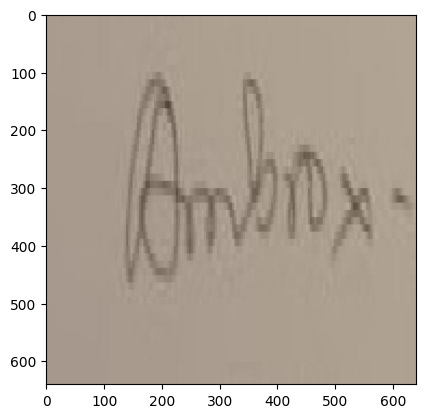

In [28]:
# Run inference on the input image...
# inp_img_url = "/mnt/hdd/projects/codeshift/model/image-detection/photos/solan/3.jpg"
OUTPUT_DIR = "output"
inp_file_name = f"1.jpg"
file_path = "medicine_name_dataset/ambrox/1.jpg"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the image
# download_file(inp_img_url, inp_file_name, directory=OUTPUT_DIR)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(file_path)

print(input_image.shape)
print(input_layer.shape)
res = compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [29]:
from pathlib import Path

import tensorflow as tf

model_xml = Path("model/medicine/medicine.xml")

In [30]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import nncf
from openvino.runtime import Core
from openvino.runtime import serialize
from PIL import Image
from sklearn.metrics import accuracy_score

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [31]:
img_height = 180
img_width = 180
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1
)

for a, b in val_dataset:
    print(type(a), type(b))
    break

Found 419 files belonging to 54 classes.
Using 83 files for validation.
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [32]:
def transform_fn(data_item):
    """
    The transformation function transforms a data item into model input data.
    This function should be passed when the data item cannot be used as model's input.
    """
    images, _ = data_item
    return images.numpy()


calibration_dataset = nncf.Dataset(val_dataset, transform_fn)

In [33]:
core = Core()
ir_model = core.read_model(model_xml)


In [34]:
quantized_model = nncf.quantize(
    ir_model,
    calibration_dataset,
    subset_size=1000
)

Applying Fast Bias correction: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


In [35]:
compressed_model_dir = Path("../../python_backend/trained_models/medicine")
compressed_model_dir.mkdir(parents=True, exist_ok=True)
compressed_model_xml = compressed_model_dir / "optimized_medicine.xml"
serialize(quantized_model, str(compressed_model_xml))

In [36]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [37]:
def validate(model, validation_loader):
    """
    Evaluate model and compute accuracy metrics.

    :param model: Model to validate
    :param validation_loader: Validation dataset
    :returns: Accuracy scores
    """
    predictions = []
    references = []

    output = model.outputs[0]

    for images, target in validation_loader:
        pred = model(images.numpy())[output]

        predictions.append(np.argmax(pred, axis=1))
        references.append(target)

    predictions = np.concatenate(predictions, axis=0)
    references = np.concatenate(references, axis=0)

    scores = accuracy_score(references, predictions)

    return scores

In [38]:
original_compiled_model = core.compile_model(model=ir_model, device_name=device.value)
quantized_compiled_model = core.compile_model(model=quantized_model, device_name=device.value)

original_accuracy = validate(original_compiled_model, val_dataset)
quantized_accuracy = validate(quantized_compiled_model, val_dataset)

print(f"Accuracy of the original model: {original_accuracy:.3f}")
print(f"Accuracy of the quantized model: {quantized_accuracy:.3f}")

Accuracy of the original model: 0.867
Accuracy of the quantized model: 0.855


In [39]:
original_model_size = model_xml.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = compressed_model_xml.with_suffix(".bin").stat().st_size / 1024

print(f"Original model size: {original_model_size:.2f} KB")
print(f"Quantized model size: {quantized_model_size:.2f} KB")

Original model size: 7804.25 KB
Quantized model size: 3903.63 KB


In [40]:
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)

    input_image = image.reshape((n, h, w, c))

    return input_image

In [41]:
class_names = sorted([item.name for item in Path(data_dir).iterdir() if item.is_dir()])
import pickle
path = Path("../../python_backend/trained_models/medicine")
pickle_file = path / 'medicine_class_list.pkl'

with open(pickle_file, 'wb') as file:
    pickle.dump(class_names, file)


with open(pickle_file, 'rb') as file:
    loaded_list = pickle.load(file)

print(f'Loaded list: {loaded_list}')

Loaded list: ['accet', 'ace_plus', 'acitix', 'adropin', 'ambrox', 'amdocalcy', 'anistovit', 'anzet', 'atova', 'atrisive', 'avolae', 'azolin', 'bost', 'caldi', 'capcet', 'caryon', 'coralceel', 'dexlin', 'dm_a', 'earo_zenole', 'easyl3fe', 'ecospin', 'edeloss', 'etoxib', 'ezylifel', 'fexo', 'flexi', 'fluclox', 'folict', 'iprasol', 'levoflex', 'lopo', 'monas', 'monaz', 'myolax', 'napa', 'napa-rapid', 'others', 'oticlor_pd', 'otosil', 'potacit', 'remood', 'renava', 'revotril', 'sergel', 'solan', 'sulprex', 'supra', 'suprab', 'tamenturbo', 'tyclav', 'viset', 'xixc_b', 'zovia_gold']


input image shape: (1, 180, 180, 3)
input layer shape: [1,180,180,3]
This image most likely belongs to avolae with a 100.00 percent confidence.


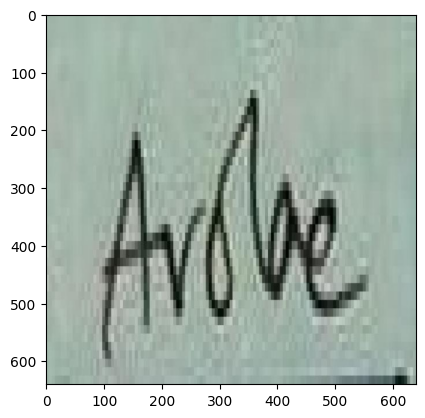

In [42]:
# Get the names of the input and output layer
# model_pot = ie.read_model(model="model/optimized/flower_ir.xml")
input_layer = quantized_compiled_model.input(0)
output_layer = quantized_compiled_model.output(0)

# Get the class names: a list of directory names in alphabetical order
class_names = sorted([item.name for item in Path(data_dir).iterdir() if item.is_dir()])

# Run inference on an input image...
inp_img_url = (
    "https://upload.wikimedia.org/wikipedia/commons/4/48/A_Close_Up_Photo_of_a_Dandelion.jpg"
)
directory = "output"
inp_file_name = "A_Close_Up_Photo_of_a_Dandelion.jpg"
file_path = "medicine_name_dataset/avolae/2.jpg"
# Download the image if it does not exist yet
# if not Path(inp_file_name).exists():
#     download_file(inp_img_url, inp_file_name, directory=directory)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(imagePath=file_path)
print(f'input image shape: {input_image.shape}')
print(f'input layer shape: {input_layer.shape}')

res = quantized_compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)